# <img src="https://uxwing.com/wp-content/themes/uxwing/download/business-professional-services/boy-services-support-icon.png" style="height: 40px"/> MLRun's Call Center Demo

In this demo we will be showcasing how we used GenAI to turn call center conversation audio files of customers and agents into valueable data in a single workflow orchastrated by MLRun.

MLRun will be automating the entire workflow, auto-scale resources as needed and automatically log and parse values between the workflow different steps.

## Table of contents:

1. [Workflow Introduction](#workflow_introduction)
2. [Data Preview](#data_preview)
3. [Running The Workflow](#running_the_workflow)
4. [Review Result](#review_result)
5. [Future Work](#future_work)

___
<a id="workflow_introduction"></a>
## 1. Workflow Introduction

<img src="images/call-center-workflow.png" style="width: 1000px"/>

The workflow include the 4 steps where all the first 3 are functions from **MLRun's functions hub**. You can see each hub function's docstring, code and example by clicking the function name in the following list:

1. [**Transcribe**]() - A **hub function** that uses [OpenAI's Whisper](https://openai.com/research/whisper) model to transcribe the calls into text and save them as text files. In addition, the following features are extracted and stored in a dataset:
   
   * `language` - The detectrerd language in the conversation.
   * `rate_of_speech` - The average speaking speed in the conversation, calculated by the amouny of words devided by the conversation length.
  
2. [**Recognize PII**]() - A **hub function** that uses 3 techniques to recognize private identfiable information: RegEx, [Flair](https://flairnlp.github.io/) and [Microsoft's Presidio Analyzer](https://microsoft.github.io/presidio/analyzer/) and [Anonymizer](https://microsoft.github.io/presidio/anonymizer/). The function clear the recognized private data and produces multiple artifacts to review and understand the recogniztion process.

3. [**Analyze**]() - A **hub function** that use a LLM to analyze a given text. It expects a prompt template and questions to send to the LLM and construct a dataset out of its answers. In this demo we will use Falcon 40B to analyze our conversation calls. It will help us extract the following features:
   
   * `issue` - The general subject of the call.
   * `summary` - The summary of the entire call in few sentences.
   * `is_fixed` - Whether the issue was rresolved by the end of the call. Can be on of {yes, no}.
   * `customer_tone` - The general customer tone durring the call. Can be one of {posetive, netural, negative}.
   * `agent_tone` - The general agent tone durring the call. Can be one of {posetive, netural, negative}.

4. [**Post-process**]() - The only **project function**. Used to preprocess the LLM's answers and join the datasets from steps 1 and 3 so we'll have the follwing schema:

   | id | audio_file | transcription_file | language | length | rate_of_speech | issue | summary | is_fixed | customer_tone | agent_tone |
   | -- | ---------- | ------------------ | -------- | ------ | -------------- | ----- | ------- | -------- | ------------- | ---------- |
   | 01 | xxx.mp3 | xxx.txt | en | 158 | 4.4 | No internet connection | ... | Yes | Negative | Posetive |
   | 02 | yyy.mp3 | yyy.txt | en | 314 | 4.02 | Payment Issues | ... | Yes | Neutral | Posetive |


___
<a id="data_preview"></a>
## 2. Data Preview

The audio calls recording data in the demo was created by the following steps:
1. We used OpenAI's [ChatGPT](https://chat.openai.com/auth/login) to generate conversations of call centers.
2. Then, we used the text-to-speech website [TTSMaker](https://ttsmaker.com/) to generate the conversations text into audio files.

> The data was created manually as a proof of concept for the demo's first version capabilities and in the next versions it will be fullly automated (see section 5 - [Future Work](#future_work))

In [1]:
import IPython
import glob

IPython.display.Audio(list(glob.glob("./data/*.mp3"))[0])

___
<a id="running_the_workflow"></a>
## 3. Running The Workflow

### 3.1. Create / Load The Project

First, we'll load the project with the function [`get_or_create_project`](https://docs.mlrun.org/en/latest/api/mlrun.projects.html#mlrun.projects.get_or_create_project). The project is being created (or loaded if previously created) and being setup automatically according to the [project_setup.py](./project_setup.py) file located in this repo. 

This file is setting the functions accoridng to the given `parameters` down below. Feel free to set them as you wish:

* `source : str` - The git repo source of the project to clone when each function is running.
* `default_image : str` - The image to use for running the workflow's functions.

In [2]:
import os
import mlrun

In [18]:
project = mlrun.get_or_create_project(
    name="call-center-demo",
    context="./",
    user_project=True,
    parameters={
        "source": "git://github.com/mlrun/demo-call-center.git#main",
        "default_image": "giladsh28/llm:v3",
        "gpus": 4,
    },
)

Project Source: git://github.com/mlrun/demo-call-center.git#main
> 2023-08-27 17:20:13,926 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/User/demos/call-center-demo'}
> 2023-08-27 17:20:14,431 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': 'src', 'error': '/User/demos/call-center-demo/src'}
Using GPUs for question asnwering.
> 2023-08-27 17:20:14,804 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': 'src', 'error': '/User/demos/call-center-demo/src'}
> 2023-08-27 17:20:15,006 [info] Project loaded successfully: {'project_name': 'call-center-demo'}


### 3.2. Run The Workflow

Let us run the described workflow by calling the project's method [`run`](https://docs.mlrun.org/en/latest/api/mlrun.projects.html#mlrun.projects.MlrunProject.run). The workflow code running can be found in the [src/workflow.py](./src/workflow.py) file located in this repo. 

Parameters passed to the function can be adjusted according to the workflow `arguments`. Feel free to set them as you wish:

* `input_path : str` - Path to the conversation audio files directory.
* `transcribe_model : str` - The model to use for the transcribe function. Must be one of the official model names listed [here](https://github.com/openai/whisper#available-models-and-languages).
* `pii_model : str` - The model to use. Can be "spacy", "flair", "pattern" or "whole".
* `pii_entities : Listr[str]` - The list of entities to recognize.
* `qa_model : str` - The model to use for asnwering the given questions.
* `qa_questions : Listr[str]` - A list of questions to ask the LLM chosen about the conversations.
* `qa_questions_columns : Listr[str]` - A list of columns to store the LLM asnwers in.

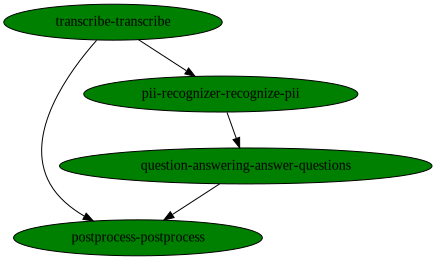

uid,start,state,name,parameters,results
...9d1462b3,Aug 27 18:33:45,completed,postprocess-postprocess,,
...256c21c5,Aug 27 17:22:38,completed,question-answering-answer-questions,"model=tiiuae/falcon-40b-instructmodel_kwargs={'device_map': 'auto', 'load_in_8bit': True}text_wrapper=Given the following conversation between a Customer and a Call Center Agent:\n-----\n{}\n-----questions=['Classify the Customer issue in 1-4 words.', 'Write a 50-100 word summary of the text.', 'Was the Customer issue fixed, Yes or No?', 'In one word, was the Customer tone Positive, Negative or Neutral?', 'In one word, was the Call Center Agent tone Positive, Negative or Neutral?']questions_columns=['Issue', 'Summary', 'is_fixed', 'customer_tone', 'agent_tone']generation_config={'do_sample': True, 'temperature': 0.8, 'top_p': 0.9, 'early_stopping': True, 'max_new_tokens': 150}",question_answering_errors={}
...099fe08d,Aug 27 17:22:02,completed,pii-recognizer-recognize-pii,"model=wholeoutput_path=./cleaned_dataoutput_suffix=outputhtml_key=highlightedentities=['PERSON', 'EMAIL', 'PHONE', 'LOCATION', 'ORGANIZATION']entity_operator_map={'PERSON': ['replace', {'new_value': 'John Doe', 'entity_type': 'PERSON'}], 'EMAIL': ['replace', {'new_value': 'john_doe@email.com'}], 'PHONE': ['replace', {'new_value': '123456789'}], 'LOCATION': ['replace', {'new_value': 'USA'}], 'ORGANIZATION': ['replace', {'new_value': 'Call Center Agent', 'entity_type': 'ORGANIZATION'}]}score_threshold=0.8",
...5091c8e1,Aug 27 17:20:38,completed,transcribe-transcribe,input_path=/User/demos/call-center-demo/datadecoding_options={'fp16': False}model_name=tinyoutput_directory=./transcripted_data,


In [19]:
workflow_run = project.run(
    name="workflow",
    arguments={
        "input_path": os.path.abspath("./data"),
        "transcribe_model": "tiny",
        "pii_model": "whole",
        "pii_entities": ['PERSON', "EMAIL", "PHONE", "LOCATION", "ORGANIZATION"],
        "pii_entity_operator_map": {
            "PERSON": ("replace", {"new_value": "John Doe"}),
            "EMAIL": ("replace", {"new_value": "john_doe@email.com"}),
            "PHONE": ("replace", {"new_value": "123456789"}),
            "LOCATION": ("replace", {"new_value": "USA"}),
            "ORGANIZATION": ("replace", {"new_value": "Call Center Agent"}),
        },
        "qa_model": "tiiuae/falcon-40b-instruct",
        "qa_questions":[
            "Classify the Customer issue in 1-4 words.",
            "Write a 50-100 word summary of the text.",
            "Was the Customer issue fixed, Yes or No?",
            "In one word, was the Customer tone Positive, Negative or Neutral?",
            "In one word, was the Call Center Agent tone Positive, Negative or Neutral?"
        ],
        "qa_questions_columns":[
            "Issue",
            "Summary",
            "is_fixed",
            "customer_tone",
            "agent_tone",
        ]
    },
    watch=True,
    dirty=True,
    timeout=60 * 120,
)

___
<a id="review_result"></a>
## 4. Review Result

The workflow is done and we can now view the data and features we collected from our conversations audio files. 

> Keep in mind we will cover here only the final product, but each step in the workflow is automatically logged and can be viewed as well. MLRun's experiment tracking enables full exploration and reproducibility between steps in a workflow due to its automatic logging features.

In [20]:
project.get_artifact(key="postprocess-postprocess_final_df").to_dataitem().as_df()

,audio_file,transcription_file,language,length,rate_of_speech,Issue,Summary,is_fixed,customer_tone,agent_tone
2,ttsmaker-file-2023-7-10-14-44-41.mp3,ttsmaker-file-2023-7-10-14-44-41.txt,en,137.400000,3.151383,Damaged product,The Customer was disappointed with the product...,Yes,Positive,Neutral
3,ttsmaker-file-2023-7-10-14-47-23.mp3,ttsmaker-file-2023-7-10-14-47-23.txt,en,187.537958,2.586143,Terrible service,The Customer was dissatisfied with the service...,Yes,Negative,Positive
4,ttsmaker-file-2023-7-10-14-49-29.mp3,ttsmaker-file-2023-7-10-14-49-29.txt,en,240.577958,2.510621,Defective Product,A customer has been experiencing issues with a...,Unknown,Negative,Positive
5,ttsmaker-file-2023-7-10-19-27-6.mp3,ttsmaker-file-2023-7-10-19-27-6.txt,en,149.857958,2.282161,Order not shipped yet,A customer placed an order and wants to know w...,Yes,Positive,Positive
6,ttsmaker-file-2023-7-10-19-29-34.mp3,ttsmaker-file-2023-7-10-19-29-34.txt,en,173.569958,2.310308,Incorrect charge on billing statement,A customer had an issue with an incorrect char...,Yes,Positive,Neutral
7,ttsmaker-file-2023-7-10-19-32-43.mp3,ttsmaker-file-2023-7-10-19-32-43.txt,en,231.793958,2.553992,<strong>Product Defects</strong>,The Customer was dissatisfied with their exper...,No,Negative,Positive
8,ttsmaker-file-2023-7-10-19-38-39.mp3,ttsmaker-file-2023-7-10-19-38-39.txt,en,181.249958,2.576552,Messed up service,The customer had issues with the product and s...,No,Negative,Positive
9,ttsmaker-file-2023-7-10-19-41-5.mp3,ttsmaker-file-2023-7-10-19-41-5.txt,en,198.745958,2.465459,"Poor product quality, unhelpful customer support",The text is a conversation between a customer ...,Yes,Negative,Positive
10,ttsmaker-file-2023-7-10-19-52-34.mp3,ttsmaker-file-2023-7-10-19-52-34.txt,en,231.817958,2.389806,Defective product and inadequate customer support,The conversation is between a Customer and a C...,Unknown,Neutral,Neutral


___
<a id="future_work"></a>
## 5. Future Work

This demo was a proof of concept for LLMs feature extraction capabilities. We demonstrated it works and the demo is now being further developed so in version 2 it will feature the following:
* **Data Generation Workflow** - A workflow for conversation audio files using OpenAI's ChatGPT via a given prompt and [bark](https://github.com/suno-ai/bark) for text to speech using 2 voices - one for each person in the conversation.
* **Data Storage** - Generated data files will be uploaded into a data storage like S3.
* **[MySQL](https://www.mysql.com/) as Relational DB** - All features extracted will be saved in a MySQL DB.
* **[Milvus](https://milvus.io/) as Vecftor DB** - PII free transcription will be saved in a Milvus DB for further data analysis.
* **Data Analysis Workflow** - Workflow to analyze the collected data from the RDB and VDB.
* **Improved Transcription Workflow** - The hub functions used in this demo's workflow will be improved. Some exmaples include:
  * The `transcribe` function will support receiving time windows for specific transcription per person. 
  * In addition, there will be a new `speaker_diarisation` Function to get the time windows for each speeker.
* **FE Applications** - Fully realtime GUI applications for data collection and analysis. The FE is develoepd using [Gradio](https://www.gradio.app/) 
* And more!